In [3]:
import matplotlib.pyplot as plt
import control as ct
import numpy as np
import os
import pandas as pd

t_step = 0.1       # Momento exacto donde cambia d

nombre_archivo = r"C:\Users\HÉCTOR\Documents\Control\Control-Clasico\datos\eperimeto1.txt"

if not os.path.exists(nombre_archivo):
    print(f"ERROR: No se encuentra el archivo en: {nombre_archivo}")
else:
    try:
        # 1. CARGA DE DATOS
        datos = np.loadtxt(nombre_archivo, delimiter=',')
        
        # Usamos las variables qcargadas
        t = datos[:, 0]  # Tiempo
        y = datos[:, 1]  # Vpv

        print(f"Datos cargados. Total: {len(y)}")

        # 2. CÁLCULO DE PROMEDIOS (ESTADOS ESTACIONARIOS)
        
        # --- Para y_ss1 (Antes del escalón) ---
        # Queremos datos DONDE (t > 0.09) Y (t < 0.1)
        # 0.09 es para saltarnos la subida inicial desde 0V
        mask_inicial = (t > 0.09) & (t < t_step)
        
        # --- Para y_ss2 (Después del escalón, al final) ---
        # Simplemente tomamos los últimos 50 datos donde ya se estabilizó
        # (No necesitamos máscara compleja aquí, slicing es más rápido)
        y_final_slice = y[-50:] 

        # Verificar si encontramos datos para el inicio
        if np.any(mask_inicial):
            y_ss1 = np.mean(y[mask_inicial])
            y_ss2 = np.mean(y_final_slice)
            
            print("-" * 30)
            print(f"Voltaje Inicial (y_ss1): {y_ss1:.4f} V  (Promedio entre 0.09s y {t_step}s)")
            print(f"Voltaje Final   (y_ss2): {y_ss2:.4f} V  (Últimos 50 datos)")
            print("-" * 30)
            
            # Cálculo de la Ganancia K (Opcional, para verificar)
            #K = (y_ss2 - y_ss1) / delta_D
            #print(f"Ganancia estimada K: {K:.4f}")
            
        else:
            print("ERROR: No se encontraron datos en el intervalo 0.09s - 0.1s.")

    except Exception as e:
        print(f"Ocurrió un error: {e}")

Datos cargados. Total: 4001
------------------------------
Voltaje Inicial (y_ss1): 14.5982 V  (Promedio entre 0.09s y 0.1s)
Voltaje Final   (y_ss2): 18.5870 V  (Últimos 50 datos)
------------------------------



Parámetros de inflexión:
  Derivada máxima (m)         = 1044.9272 V/s
  Tiempo de inflexión (t_inf) = 0.10 s
  Voltaje de inflexión (y_inf) = 14.844 V

Tiempos calculados (método de la tangente):
  t_L (intersección inferior) = 0.10017 s
  t_T (intersección superior) = 0.10398 s

--- PARÁMETROS FOPDT OBTENIDOS ---
  K = -99.72127802607424
  L = 0.00016521479010193907 s
  T = 0.003817348331866699 s


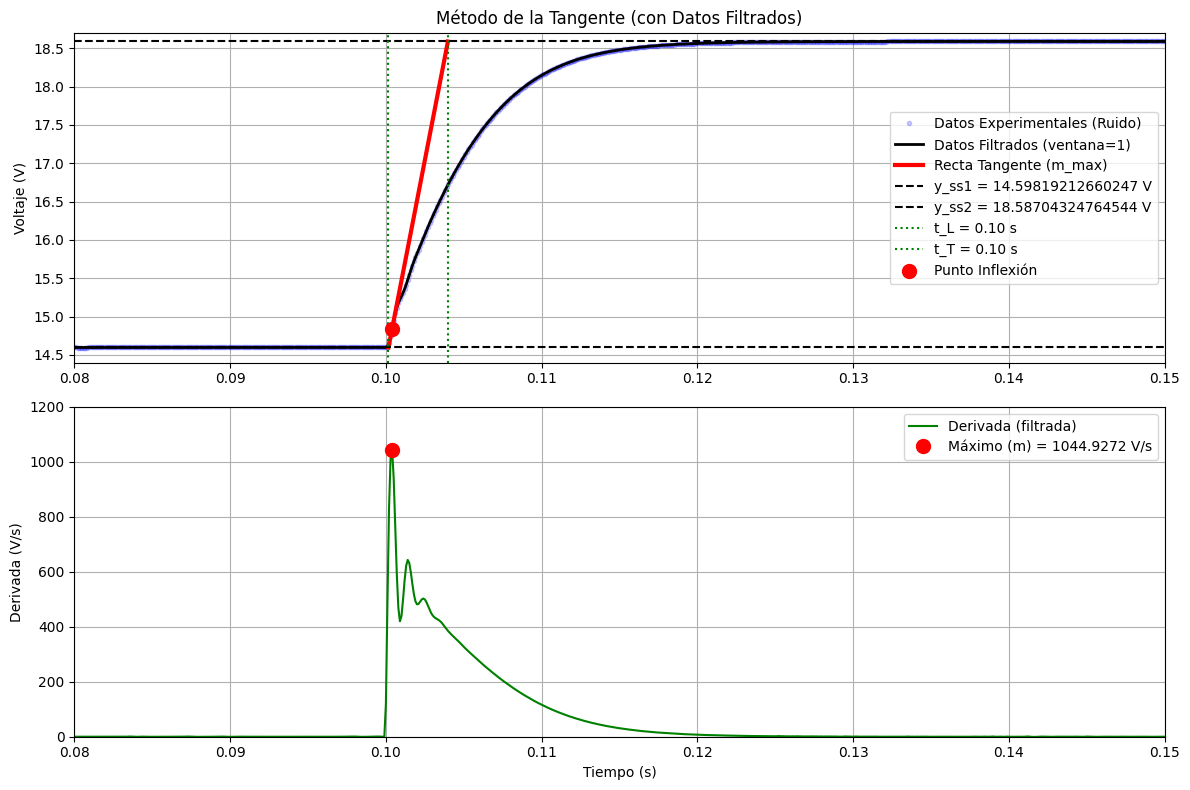

In [18]:

# --- Parámetros del experimento ---
delta_u = -0.04    # Cambio en la entrada.
t_0 = 0.1  

# --- Ventana del filtro  (Puedes ajustar este valor si es necesario, 5 o 7 es un buen inicio) ---
window_size = 1

try:
    # --- 1. Importar datos 
    # Usamos pandas para cargar, luego convertimos a NumPy.
    data = pd.read_csv(nombre_archivo, header=None, names=['Tiempo', 'V_pv'])
    
 
    # --- 2. Convertir ADC a Voltaje y aplica el filtro ---   
    # Convertir a Series de pandas
    data['t_seg'] = data['Tiempo'] 
    ##data['V_pv'] = data[] 

    # Aplicar un filtro de media móvil para suavizar el ruido
    data['y_voltaje_filtrado'] = data['V_pv'].rolling(window=window_size, center=True).mean()
    
    # Descartar las filas con NaN (generadas en los bordes por el filtro)
    data = data.dropna()
    
    # Ahora convertir a arrays de NumPy para los cálculos
    t_seg = data['t_seg'].to_numpy()
    y_voltaje_ruido = data['V_pv'].to_numpy()       # Voltaje original
    y_voltaje_filtrado = data['y_voltaje_filtrado'].to_numpy() # Voltaje filtrado
    

    # --- 3. Calcular la derivada sobre datos filtrados ---
    # np.diff() calcula la diferencia entre elementos consecutivos (ej. y[1]-y[0])
    dy = np.diff(y_voltaje_filtrado)
    dt = np.diff(t_seg)
    
    # Evitar división por cero si el tiempo entre muestras es 0 al asignar un valor muy pequeño
    dt[dt == 0] = 1e-9
    
    derivada = dy / dt
    
    # El array 'derivada' tiene N-1 elementos.
    # Asociamos la derivada[i] al tiempo[i] (el inicio del intervalo)
    t_derivada = t_seg[:-1] # Todos los tiempos excepto el último


    # --- 4. Encontrar el punto de inflexión (derivada máxima) PERO SOLO DESPUÉS DEL ESCALÓN ---

    # Filtrar sólo cuando ya ocurrió el escalón
    mask_escalon = t_derivada > t_step

    if not np.any(mask_escalon):
        raise ValueError("No hay datos después del escalón para analizar la derivada.")

    # Derivada y tiempo SOLO en la región del escalón
    deriv_escalon = derivada[mask_escalon]
    t_deriv_escalon = t_derivada[mask_escalon]

    # Máxima derivada en la región del escalón
    m = np.max(deriv_escalon)
    idx_rel = np.argmax(deriv_escalon)

    # Convertir índice relativo → índice absoluto en los vectores originales
    idx_max = np.where(mask_escalon)[0][idx_rel]

    # Extraer tiempos y valores correctos
    t_inflexion = t_derivada[idx_max]
    y_inflexion = y_voltaje_filtrado[idx_max]



    # --- 5. Calcular L y T analíticamente (Método de Ziegler-Nichols) ---
    # Calcular las intersecciones de la recta tangente
    t_L = t_inflexion + (y_ss1 - y_inflexion) / m
    t_T = t_inflexion + (y_ss2 - y_inflexion) / m
    
    # Calcular los parámetros L y T
    L = t_L - t_0
    
    T = t_T - t_L
    
    # Calcular la Ganancia K
    K = (y_ss2 - y_ss1) / delta_u

    # --- 6. Impresión de Resultados ---    
    print("\nParámetros de inflexión:")
    print(f"  Derivada máxima (m)         = {m:.4f} V/s")
    print(f"  Tiempo de inflexión (t_inf) = {t_inflexion:.2f} s")
    print(f"  Voltaje de inflexión (y_inf) = {y_inflexion:.3f} V")
    
    print("\nTiempos calculados (método de la tangente):")
    print(f"  t_L (intersección inferior) = {t_L:.5f} s")
    print(f"  t_T (intersección superior) = {t_T:.5f} s")

    print("\n--- PARÁMETROS FOPDT OBTENIDOS ---")
    print(f"  K = {K}")
    print(f"  L = {L} s")
    print(f"  T = {T} s")


    # --- 7. Visualización en la gráfica. ---
    # Calcular la línea tangente para graficarla
    b_tangente = y_inflexion - m * t_inflexion
    t_graf_tangente = np.array([t_L, t_T])
    y_graf_tangente = m * t_graf_tangente + b_tangente

    plt.figure(figsize=(12, 8))
    
    # Gráfica 1: Datos y Tangente
    # Graficamos los datos originales (con ruido) Y los datos filtrados
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(t_seg, y_voltaje_ruido, 'b.', label='Datos Experimentales (Ruido)', alpha=0.2)
    ax1.plot(t_seg, y_voltaje_filtrado, 'k-', linewidth=2, label=f'Datos Filtrados (ventana={window_size})')
    
    ax1.plot(t_graf_tangente, y_graf_tangente, 'r-', linewidth=3, label='Recta Tangente (m_max)')
    ax1.axhline(y=y_ss1, color='k', linestyle='--', label=f'y_ss1 = {y_ss1} V')
    ax1.axhline(y=y_ss2, color='k', linestyle='--', label=f'y_ss2 = {y_ss2} V')
    ax1.axvline(x=t_L, color='g', linestyle=':', label=f't_L = {t_L:.2f} s')
    ax1.axvline(x=t_T, color='g', linestyle=':', label=f't_T = {t_T:.2f} s')
    ax1.plot(t_inflexion, y_inflexion, 'ro', markersize=10, label='Punto Inflexión')
    
    ax1.set_title('Método de la Tangente (con Datos Filtrados)')
    ax1.set_ylabel('Voltaje (V)')
    ax1.legend()
    ax1.grid(True)

    # Gráfica 2: Derivada
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    ax2.plot(t_derivada, derivada, 'g-', label='Derivada (filtrada)') 
    ax2.plot(t_inflexion, m, 'ro', markersize=10, label=f'Máximo (m) = {m:.4f} V/s')
    ax2.set_xlabel('Tiempo (s)')
    ax2.set_ylabel('Derivada (V/s)')
    ax2.legend()
    ax2.grid(True)
    
    zoom_inicio = t_step - 0.02
    zoom_fin    = t_step + 0.05

    ax1.set_xlim(zoom_inicio, zoom_fin)
    ax1.set_ylim(14.4, 18.7)
    
    ax2.set_xlim(zoom_inicio, zoom_fin)
    ax2.set_ylim(0, 1200)

    
    plt.tight_layout()
    plt.show()


except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{nombre_archivo}'")
    print("Por favor, asegúrese que el archivo .txt está en la misma carpeta que el script.")
    
except Exception as e:
    print(f"Ha ocurrido un error inesperado: {e}")


Función de Transferencia del Modelo (FOPDT):
         -99.72127802607424 * e^(-0.00016521479010193907s)
  G(s) = --------------------------
         0.003817348331866699s + 1



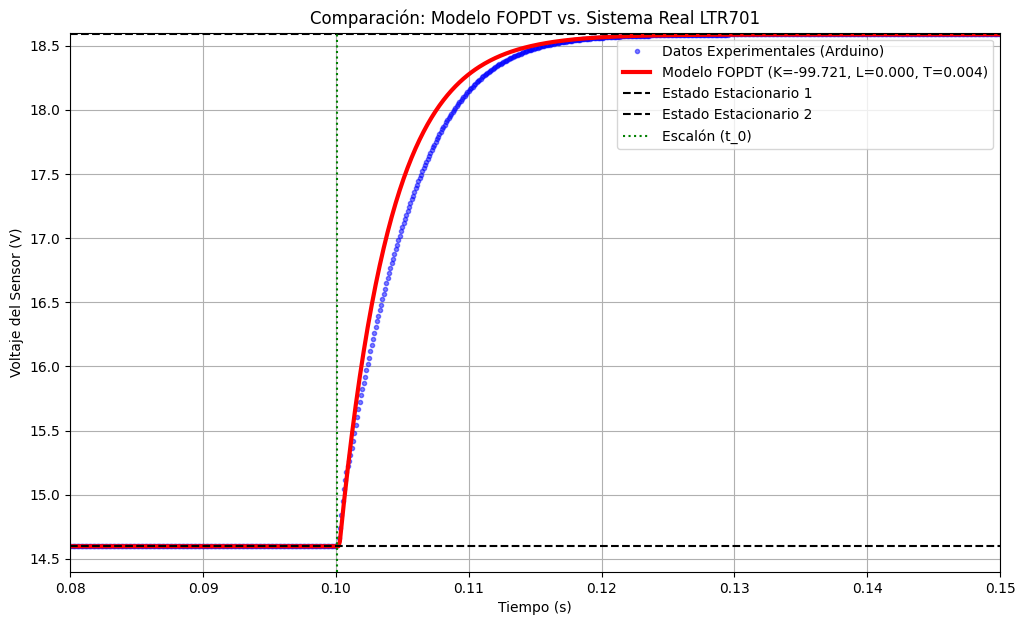

In [ ]:

# --- Parámetros obtenidos del análisis (REEMPLAZAR CON SUS VALORES) ---
t_in = t_step     
# --- Definir e imprimir la Función de Transferencia (FT) ---
print("\n" + "="*40)
print("Función de Transferencia del Modelo (FOPDT):")
print(f"         {K} * e^(-{L}s)")
print(f"  G(s) = {'-' * (len(str(T)) + 6)}")
print(f"         {T}s + 1")
print("="*40 + "\n")


try:
    # Cargar datos del Arduino (Tiempo en ms, Valor ADC)
    #data = pd.read_csv(nombre_archivo, header=None, names=['Tiempo', 'Vpv'])
    
    # Convertir a segundos y voltaje
    t_exp = data['t_seg'] 
    y_exp = data['V_pv'] 
    

    t_0 = t_exp[t_exp > t_in].iloc[0] # Encuentra el tiempo del escalón (ej. 50s)

    # --- Crear la respuesta del modelo FOPDT ---
    t_sim = t_exp.copy()
    y_sim = np.zeros_like(t_sim)

    for i, t in enumerate(t_sim):
        if t < (t_0 + L):
            y_sim[i] = y_ss1
        else:
            # Ecuación de respuesta al escalón de un FOPDT
            # y = y_inicial + (Ganancia_Total) * (1 - e^(-(t - t_escalon - L) / T))
            y_sim[i] = y_ss1 + (K * delta_u) * (1 - np.exp(-(t - t_0 - L) / T))
            
            # Limitar la respuesta al valor final por si el modelo sobrepasa
            if y_sim[i] > y_ss2:
                y_sim[i] = y_ss2

    # --- Graficar la comparación ---
    plt.figure(figsize=(12, 7))
    plt.plot(t_exp, y_exp, 'b.', label='Datos Experimentales (Arduino)', alpha=0.5)
    plt.plot(t_sim, y_sim, 'r-', linewidth=3, label=f'Modelo FOPDT (K={K:.3f}, L={L:.3f}, T={T:.3f})')
    plt.axhline(y=y_ss1, color='k', linestyle='--', label='Estado Estacionario 1')
    plt.axhline(y=y_ss2, color='k', linestyle='--', label='Estado Estacionario 2')
    plt.axvline(x=t_0, color='g', linestyle=':', label='Escalón (t_0)')
    
    plt.title('Comparación: Modelo FOPDT vs. Sistema Real LTR701')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Voltaje del Sensor (V)')
    plt.legend()
    plt.grid(True)
    
    plt.xlim(0.08, 0.15)   
    plt.ylim(14.4, 18.6)       

    plt.show()

except FileNotFoundError:
    print(f"Error: No se encontró el archivo {nombre_archivo}")
    print("Por favor, guarde sus datos del Arduino con ese nombre en la misma carpeta.")

In [19]:

#Creacin de Gp(s)
print(f"K = {K}")
print(f"L = {L}")
print(f"T = {T}")

num = [-99.702]
den = [0.003, 1]

Gp = ct.tf(num,den)

print("\nFunción de Transferencia de la Planta Gp(s):")
print(Gp)

K = -99.72127802607424
L = 0.00016521479010193907
T = 0.003817348331866699

Función de Transferencia de la Planta Gp(s):
<TransferFunction>: sys[86]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     -99.7
  -----------
  0.003 s + 1


### Reglas de Sintonización de Ziegler-Nichols (Lazo Abierto)

Ziegler y Nichols propusieron una tabla de sintonización empírica basada en los parámetros $K$, $L$ y $T$ de la curva S.

**Tabla de Sintonización de Ziegler-Nichols (Método 1):**

| Tipo de Controlador | $K_p$ | $T_i$ | $T_d$ |
| :--- | :--- | :--- | :--- |
| P | $T / (K \cdot L)$ | $\infty$ | $0$ |
| PI | $0.9 \cdot T / (K \cdot L)$ | $L / 0.3$ | $0$ |
| **PID** | **$1.2 \cdot T / (K \cdot L)$** | **$2L$** | **$0.5L$** |

Usaremos las fórmulas de la fila **PID**. Las conversiones de $T_i$ y $T_d$ a las ganancias $K_i$ y $K_d$ son:

* $K_i = K_p / T_i$
* $K_d = K_p \cdot T_d$

In [ ]:

print(f"K = {K}")
print(f"L = {L}")
print(f"T = {T}")

L1 = L
K1 = K
T1 = K
# Aplicamos las fórmulas de la tabla para un PID
Kp_zn = (1.2 * T) / (K * L)
Ti_zn = 2 * L
Td_zn = 0.5 * L


print("\nVALOR DE Ti: ")
print(Ti_zn)
print("\nVALOR DE Td: ")
print(Td_zn)

# Convertimos a las ganancias Kp, Ki, Kd
Ki_zn = Kp_zn / Ti_zn
Kd_zn = Kp_zn * Td_zn

print("\n--- Ganancias Iniciales (Ziegler-Nichols) ---")
print(f"Kp = {Kp_zn}")
print(f"Ki = {Ki_zn}")
print(f"Kd = {Kd_zn}")

K = -99.72127802607424
L = 0.00016521479010193907
T = 0.003817348331866699

VALOR DE Ti: 
0.00033042958020387814

VALOR DE Td: 
8.260739505096953e-05

--- Ganancias Iniciales (Ziegler-Nichols) ---
Kp = -0.2780393588087169
Ki = -841.4481495184663
Kd = -2.296810715282994e-05



--- Ganancias Iniciales (Ziegler-Nichols) ---
Kp = -0.2780393588087169
Ki = -841.4481495184663
Kd = -2.296810715282994e-05

Función de Transferencia del sistema de lazon cerrado con controlador Proporcional-Integral-Derivativo:
<TransferFunction>: sys[106]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  0.00229 s^2 + 27.72 s + 8.389e+04
  ---------------------------------
  0.00529 s^2 + 28.72 s + 8.389e+04

Las raíces de s (polos) del sistema controlado son:
[-2714.67519461+2913.6971448j -2714.67519461-2913.6971448j]


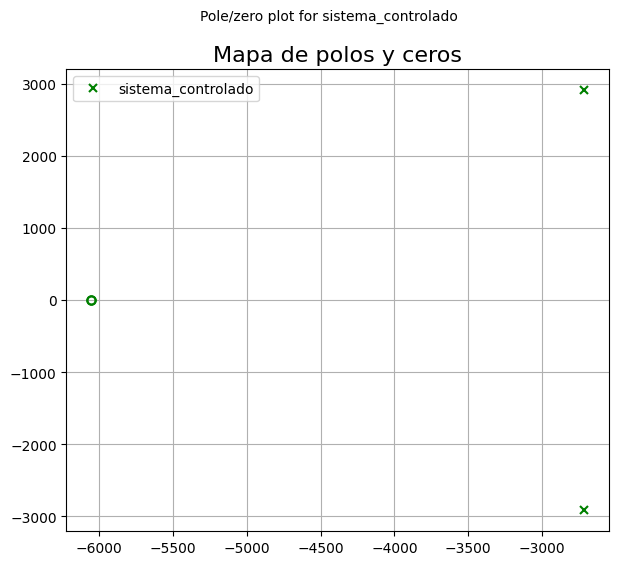

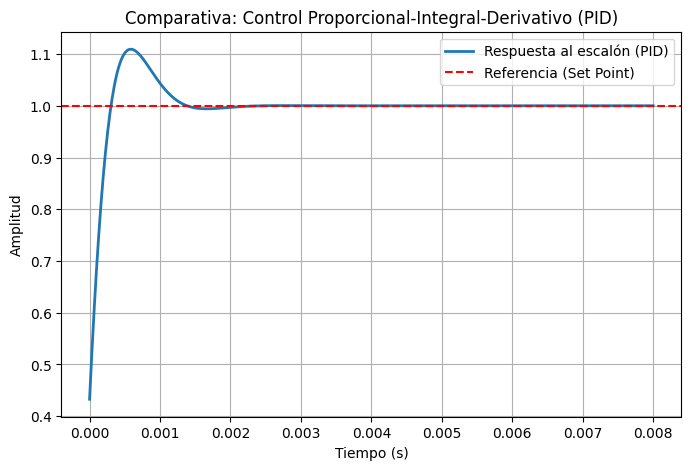

Métricas de desempeño del sistema con controlador Proporcional-Integral-Derivativo:
  - Sobreimpulso (Overshoot): 10.93%
  - Tiempo de establecimiento (SettlingTime): 0.00 s
  - Valor final: 1.0000
  - Error en estado estacionario (1 - valor_final): 0.0000


In [22]:

print("\n--- Ganancias Iniciales (Ziegler-Nichols) ---")
print(f"Kp = {Kp_zn}")
print(f"Ki = {Ki_zn}")
print(f"Kd = {Kd_zn}")

Kd = Kd_zn * 1
Kp = Kp_zn * 1
Ki = Ki_zn * 1

# --- 4. Creación del Controlador PID y Simulación ---

Gc_zn = ct.tf([Kd, Kp, Ki], [1, 0])

sistema_PID = ct.feedback(Gc_zn * Gp, 1)

# Simulación de la respuesta al escalón.
# ct.step_response calcula la respuesta a un escalón de magnitud 1.
t_sim, y_unit_step = ct.step_response(sistema_PID, T=np.linspace(0, 5, 1000))

# --- Sistema en lazo cerrado con controlador PD. ---
print("\nFunción de Transferencia del sistema de lazon cerrado con controlador Proporcional-Integral-Derivativo:")
print(sistema_PID)

polos_PID = ct.poles(sistema_PID)

# --- Simulación de la respuesta al escalón. ---
t = np.linspace(0, 0.008, 501)
t_PID, y_PID = ct.step_response(sistema_PID, T=t)

print("\nLas raíces de s (polos) del sistema controlado son:")
print(polos_PID)


# ==========================================
# GRÁFICA 1: Mapa de Polos y Ceros
# ==========================================
plt.figure(figsize=(7, 6))
plt.title('Mapa de polos y ceros', fontsize=16)
ct.pzmap(sistema_PID, label="sistema_controlado", color='green')
plt.grid(True)
plt.legend()
plt.show() # Cierra la primera figura

# ==========================================
# GRÁFICA 2: Respuesta con Referencia
# ==========================================
plt.figure(figsize=(8, 5))
plt.title("Comparativa: Control Proporcional-Integral-Derivativo (PID)")

# 1. La señal del sistema
plt.plot(t_PID, y_PID, label="Respuesta al escalón (PID)", linewidth=2)

# 2. LA REFERENCIA (Línea en 1)
# axhline dibuja una línea horizontal en todo el eje
plt.axhline(y=1, color='red', linestyle='--', label="Referencia (Set Point)")

plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)
plt.show() # Cierra la segunda figura

# ... (Tu código de métricas sigue igual)

# --- Verificación de las métricas de desempeño. ---
print("Métricas de desempeño del sistema con controlador Proporcional-Integral-Derivativo:")
info = ct.step_info(sistema_PID)
print(f"  - Sobreimpulso (Overshoot): {info['Overshoot']:.2f}%")
print(f"  - Tiempo de establecimiento (SettlingTime): {info['SettlingTime']:.2f} s")
valor_final = y_PID[-1]
print(f"  - Valor final: {valor_final:.4f}")
print(f"  - Error en estado estacionario (1 - valor_final): {1 - valor_final:.4f}")



--- Ganancias Iniciales (Ziegler-Nichols) ---
Kp = -0.2780393588087169
Ki = -841.4481495184663
Kd = -2.296810715282994e-05

Función de Transferencia del Controlador PID (con filtro):
<TransferFunction>: sys[115]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  -2.526e-05 s^2 - 0.2798 s - 210.4
  ---------------------------------
          8.261e-06 s^2 + s

Función de Transferencia del sistema de lazon cerrado con controlador Proporcional-Integral-Derivativo:

Las raíces de s (polos) del sistema controlado son:
[-217693.86482375+0.j   -4467.82796215+0.j    -870.13858066+0.j]


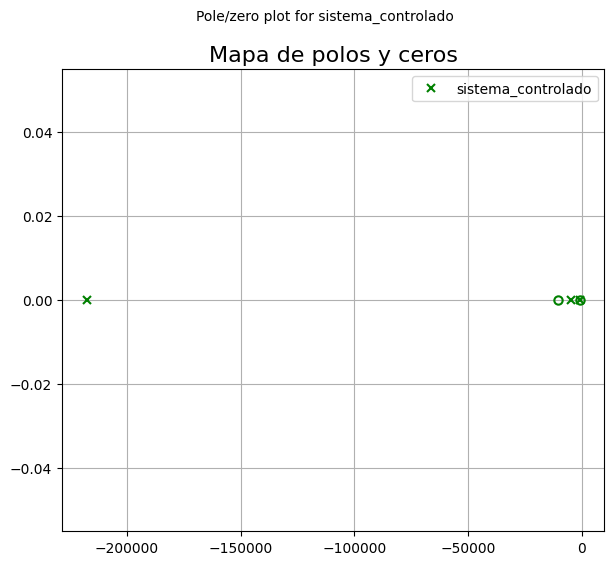

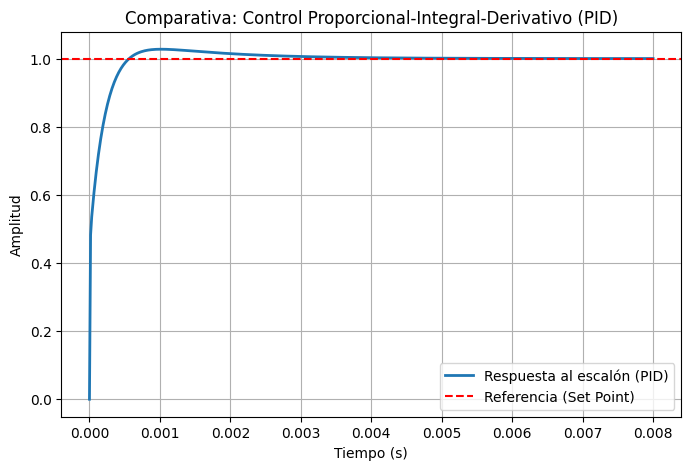

Métricas de desempeño del sistema con controlador Proporcional-Integral-Derivativo:
  - Sobreimpulso (Overshoot): 2.75%
  - Tiempo de establecimiento (SettlingTime): 0.00 s
  - Valor final: 1.0001
  - Error en estado estacionario (1 - valor_final): -0.0001


In [23]:

print("\n--- Ganancias Iniciales (Ziegler-Nichols) ---")
print(f"Kp = {Kp_zn}")
print(f"Ki = {Ki_zn}")
print(f"Kd = {Kd_zn}")

Kd = Kd_zn * 1
Kp = Kp_zn * 1
Ki = Ki_zn * 0.25

# --- 4. Creación del Controlador PID (con Filtro) ---

# 1. Coeficiente de filtrado (N).
# Un valor estándar en industria es N = 10 (mantiene el control rápido pero reduce el golpe inicial).
N = 10 

# 2. Constante de tiempo del filtro (Tf).
# Se suele calcular relacionándola con Kp y Kd.
# Esto crea un pequeño retraso necesario para que la derivada no sea infinita.
Tf = Kd / (Kp * N) 

# 3. Construcción del PID por partes
# Parte Proporcional: Kp
Cp = ct.tf([Kp], [1])

# Parte Integral: Ki / s
Ci = ct.tf([Ki], [1, 0])

# Parte Derivativa con Filtro: (Kd * s) / (Tf * s + 1)
# Esto evita que el numerador tenga un grado mayor que el denominador global
Cd_filt = ct.tf([Kd, 0], [Tf, 1])

# Sumamos las tres partes para tener el controlador completo
Gc_real = Cp + Ci + Cd_filt

# Creamos el sistema en lazo cerrado
# Usamos Gc_real en lugar del Gc_zn anterior
sistema_PID = ct.feedback(Gc_real * Gp, 1)

print("\nFunción de Transferencia del Controlador PID (con filtro):")
print(Gc_real)

# ... (El resto de tu código de simulación sigue igual) ...

# Simulación de la respuesta al escalón.
# ct.step_response calcula la respuesta a un escalón de magnitud 1.
t_sim, y_unit_step = ct.step_response(sistema_PID, T=np.linspace(0, 5, 501))

# --- Sistema en lazo cerrado con controlador PD. ---
print("\nFunción de Transferencia del sistema de lazon cerrado con controlador Proporcional-Integral-Derivativo:")
#print(sistema_PID)


polos_PID = ct.poles(sistema_PID)

# --- Simulación de la respuesta al escalón. ---
t = np.linspace(0, 0.008, 501)
t_PID, y_PID = ct.step_response(sistema_PID, T=t)

print("\nLas raíces de s (polos) del sistema controlado son:")
print(polos_PID)


# ==========================================
# GRÁFICA 1: Mapa de Polos y Ceros
# ==========================================
plt.figure(figsize=(7, 6))
plt.title('Mapa de polos y ceros', fontsize=16)
ct.pzmap(sistema_PID, label="sistema_controlado", color='green')
plt.grid(True)
plt.legend()
plt.show() # Cierra la primera figura

# ==========================================
# GRÁFICA 2: Respuesta con Referencia
# ==========================================
plt.figure(figsize=(8, 5))
plt.title("Comparativa: Control Proporcional-Integral-Derivativo (PID)")

# 1. La señal del sistema
plt.plot(t_PID, y_PID, label="Respuesta al escalón (PID)", linewidth=2)

# 2. LA REFERENCIA (Línea en 1)
# axhline dibuja una línea horizontal en todo el eje
plt.axhline(y=1, color='red', linestyle='--', label="Referencia (Set Point)")

plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)
plt.show() # Cierra la segunda figura

# ... (Tu código de métricas sigue igual)

# --- Verificación de las métricas de desempeño. ---
print("Métricas de desempeño del sistema con controlador Proporcional-Integral-Derivativo:")
info = ct.step_info(sistema_PID)
print(f"  - Sobreimpulso (Overshoot): {info['Overshoot']:.2f}%")
print(f"  - Tiempo de establecimiento (SettlingTime): {info['SettlingTime']:.2f} s")
valor_final = y_PID[-1]
print(f"  - Valor final: {valor_final:.4f}")
print(f"  - Error en estado estacionario (1 - valor_final): {1 - valor_final:.4f}")


--- RESULTADOS DE ASIGNACIÓN DE POLOS ---
Objetivo: Estabilizar en 0.02s con zeta=0.9
Frecuencia natural (wn): 222.22 rad/s

GANANCIAS CALCULADAS:
  Kp = -0.005215
  Ki = -1.881812
  Kd = 0.000000

resultados buenos con: 
  Kp2 = -0.002
  Ki2 = 2

--- POLOS DEL SISTEMA CERRADO ---
[-200.+96.86442097j -200.-96.86442097j]


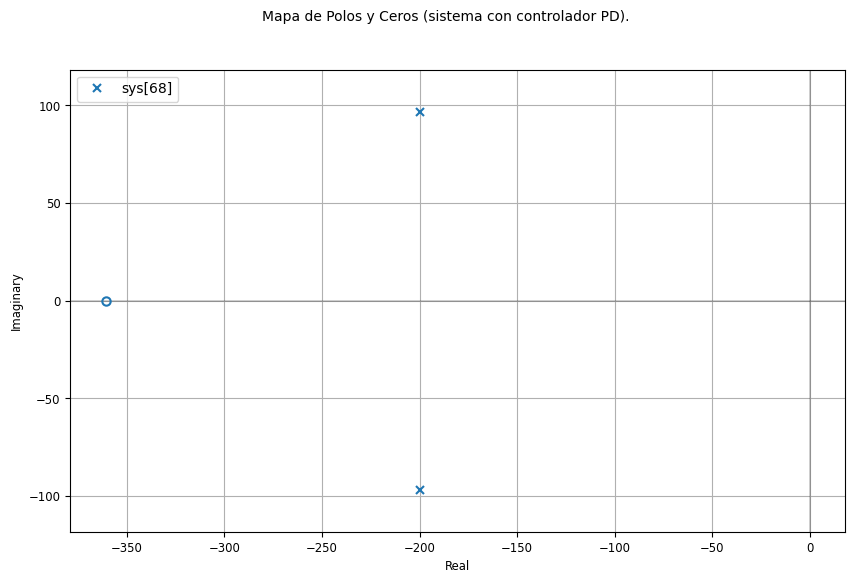

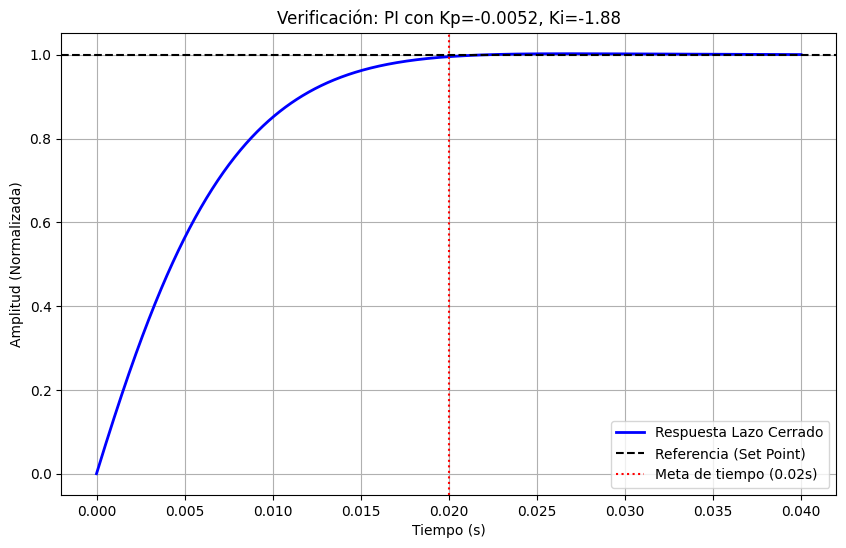


Información de la respuesta (Sintonizada, escalón unitario):
  - Sobreimpulso (Overshoot): 0.24%
  - Tiempo de Establecimiento (SettlingTime): 0.02 s
  - Valor final: 1.0004
  -Error en estado estacionario (1 -  valor_final): -0.0004


In [14]:
# --- 2. PARAMETROS DE DISEÑO 
ts_deseado = 0.02   
zeta = 0.9          

# --- 3. CÁLCULO DE GANANCIAS (Asignación de Polos) ---
# Criterio del 2% para tiempo de asentamiento: ts = 4 / (zeta * wn)
wn = 4 / (zeta * ts_deseado)

# Ecuaciones de diseño para PI en planta de 1er orden:
# Comparando coeficientes del polinomio característico deseado vs real.
Kp_calc = (2 * zeta * wn * T_planta - 1) / K_planta
Ki_calc = (wn**2 * T_planta) / K_planta
Kd_calc = 0  # En plantas de 1er orden, el derivativo no es necesario para ubicar polos

print(f"--- RESULTADOS DE ASIGNACIÓN DE POLOS ---")
print(f"Objetivo: Estabilizar en {ts_deseado}s con zeta={zeta}")
print(f"Frecuencia natural (wn): {wn:.2f} rad/s")
print(f"\nGANANCIAS CALCULADAS:")
print(f"  Kp = {Kp_calc:.6f}")
print(f"  Ki = {Ki_calc:.6f}")
print(f"  Kd = {Kd_calc:.6f}")

print("\nresultados buenos con: ")
print(f"  Kp2 = {-0.002}")
print(f"  Ki2 = {2}")


# --- 4. VERIFICACIÓN (Simulación de la respuesta) ---
# Crear función de transferencia del controlador PI
# Gc(s) = Kp + Ki/s = (Kp*s + Ki) / s
num_c = [Kp_calc, Ki_calc]
den_c = [1, 0]
Gc = ct.tf(num_c, den_c)

# Sistema en Lazo Cerrado
# H(s) = (Gc*Gp) / (1 + Gc*Gp)
H_closed_loop = ct.feedback(Gc * Gp, 1)

# Simular respuesta al escalón
# OJO: Como tu K es negativa, asumimos que tu sistema en lazo cerrado
# usa retroalimentación negativa estándar.
t_sim = np.linspace(0, ts_deseado * 2, 1000)
t, y = ct.step_response(H_closed_loop, T=t_sim)


polos = ct.poles(H_closed_loop)

print("\n--- POLOS DEL SISTEMA CERRADO ---")
print(polos)

plt.figure(figsize=(10, 6))
ct.pzmap(H_closed_loop, title='Mapa de Polos y Ceros (sistema con controlador PD).')
plt.legend()
plt.grid(True)
plt.show()



# --- 5. GRAFICAR ---
plt.figure(figsize=(10, 6))
plt.plot(t, y, 'b-', linewidth=2, label='Respuesta Lazo Cerrado')
plt.axhline(1.0, color='k', linestyle='--', label='Referencia (Set Point)')
plt.axvline(ts_deseado, color='r', linestyle=':', label=f'Meta de tiempo ({ts_deseado}s)')

plt.title(f'Verificación: PI con Kp={Kp_calc:.4f}, Ki={Ki_calc:.2f}')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (Normalizada)')
plt.grid(True)
plt.legend()
plt.show()

# Imprimir información de la respuesta sintonizada
info_tuned = ct.step_info(H_closed_loop)
print("\nInformación de la respuesta (Sintonizada, escalón unitario):")
print(f"  - Sobreimpulso (Overshoot): {info_tuned['Overshoot']:.2f}%")
print(f"  - Tiempo de Establecimiento (SettlingTime): {info_tuned['SettlingTime']:.2f} s")
valor_final = y[-1]
print(f"  - Valor final: {valor_final:.4f}")
print(f"  -Error en estado estacionario (1 -  valor_final): {1 - valor_final:.4f}")



--- RESULTADOS PID ---
Objetivo: Estabilizar en 0.02s
Kp = -0.005215
Ki = -1.881812
Kd = 0.000000

 Funcion de trasnferencia
<TransferFunction>: sys[86]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     -99.7
  -----------
  0.003 s + 1

 Funcion de trasnferencia PID
<TransferFunction>: sys[123]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  -0.005215 s - 1.882
  -------------------
           s

 Funcion de trasnferencia Lazo cerrado
<TransferFunction>: sys[126]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

       0.5199 s + 187.6
  --------------------------
  0.003 s^2 + 1.52 s + 187.6

--- UBICACIÓN DE LOS POLOS (Lazo Cerrado) ---
[-293.6872619 +0.j -212.94811716+0.j]


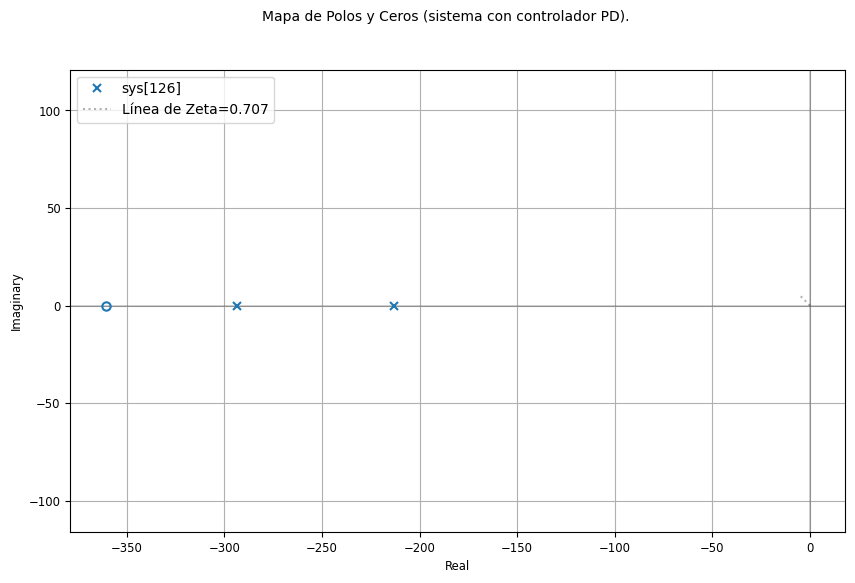

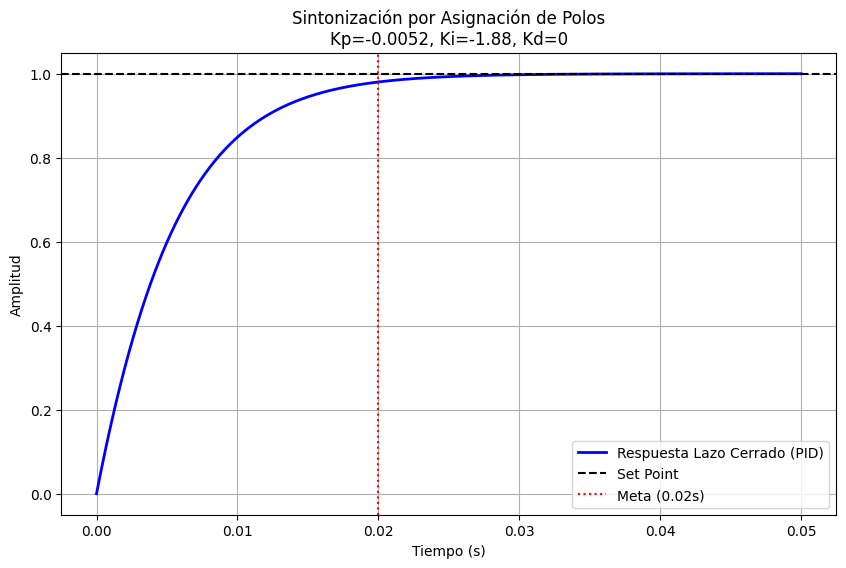


Información de la respuesta (Sintonizada, escalón unitario):
  - Sobreimpulso (Overshoot): 0.00%
  - Tiempo de Establecimiento (SettlingTime): 0.02 s
  - Valor final: 1.0000
  -Error en estado estacionario (1 -  valor_final): 0.0000
Parte real esperada: -200.00


In [24]:
# --- 2. PARAMETROS DE DISEÑO ---
ts_deseado = 0.02   # 20ms para estabilizar
zeta = 0.9          # Amortiguamiento (sin oscilaciones bruscas)

# --- 3. CÁLCULO DE GANANCIAS (Asignación de Polos) ---
wn = 4 / (zeta * ts_deseado)

# Fórmulas de Asignación de Polos para planta de 1er Orden
Kp_calc = (2 * zeta * wn * T_planta - 1) / K_planta
Ki_calc = (wn**2 * T_planta) / K_planta
Kd_calc = 0  # Se mantiene en 0 por ser planta de 1er orden, pero la variable existe.

print(f"\n--- RESULTADOS PID ---")
print(f"Objetivo: Estabilizar en {ts_deseado}s")
print(f"Kp = {Kp_calc:.6f}")
print(f"Ki = {Ki_calc:.6f}")
print(f"Kd = {Kd_calc:.6f}")

# --- 4. IMPLEMENTACIÓN DE LA FUNCIÓN DE TRANSFERENCIA ---
print("\n Funcion de trasnferencia")
print(Gp)

# Controlador PID Completo: Gc(s) = (Kd*s^2 + Kp*s + Ki) / s
# Aunque Kd sea 0, lo ponemos en el numerador para mantener la estructura general.
num_c = [Kd_calc, Kp_calc, Ki_calc]
den_c = [1, 0]
Gc2 = ct.tf(num_c, den_c)

print("\n Funcion de trasnferencia PID")
print(Gc2)

# Sistema en Lazo Cerrado
# H(s) = (Gc*Gp) / (1 + Gc*Gp)
H2_closed_loop = ct.feedback(Gc2 * Gp, 1)

print("\n Funcion de trasnferencia Lazo cerrado")
print(H2_closed_loop)

# --- 5. SIMULACIÓN ---
t_sim = np.linspace(0, ts_deseado * 2.5, 1000)
t, y = ct.step_response(H2_closed_loop, T=t_sim)
###########################################################
print("\n--- UBICACIÓN DE LOS POLOS (Lazo Cerrado) ---")
# Usamos .poles() en plural o el método del objeto
polos = ct.poles(H2_closed_loop)
print(polos)

plt.figure(figsize=(10, 6))
ct.pzmap(H2_closed_loop, title='Mapa de Polos y Ceros (sistema con controlador PD).')
# Dibujar línea de amortiguamiento constante (zeta = 0.707 equivale a 45 grados)
plt.plot([0, -5], [0, 5], 'k:', alpha=0.3, label='Línea de Zeta=0.707') 
plt.legend()
plt.grid(True)
plt.show()

###########################################################

# --- 6. GRAFICAR ---
plt.figure(figsize=(10, 6))
# Nota: Como K_planta es negativa, la respuesta matemática sale invertida.
# En la realidad, tu código C manejará el signo. Aquí visualizamos la magnitud de la corrección.
plt.plot(t, y, 'b-', linewidth=2, label='Respuesta Lazo Cerrado (PID)')
plt.axhline(1.0, color='k', linestyle='--', label='Set Point')
plt.axvline(ts_deseado, color='r', linestyle=':', label=f'Meta ({ts_deseado}s)')

plt.title(f'Sintonización por Asignación de Polos\nKp={Kp_calc:.4f}, Ki={Ki_calc:.2f}, Kd={Kd_calc}')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()
plt.show()

# Imprimir información de la respuesta sintonizada
info_tuned = ct.step_info(H2_closed_loop)
print("\nInformación de la respuesta (Sintonizada, escalón unitario):")
print(f"  - Sobreimpulso (Overshoot): {info_tuned['Overshoot']:.2f}%")
print(f"  - Tiempo de Establecimiento (SettlingTime): {info_tuned['SettlingTime']:.2f} s")
valor_final = y[-1]
print(f"  - Valor final: {valor_final:.4f}")
print(f"  -Error en estado estacionario (1 -  valor_final): {1 - valor_final:.4f}")

# Verificación rápida: La parte real debería ser aprox -zeta * wn
parte_real_esperada = -zeta * wn
print(f"Parte real esperada: {parte_real_esperada:.2f}")